In [6]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
class soft_margin_SVM(BaseEstimator, ClassifierMixin):
    '''
    ソフトマージンSVMクラス．マージン最適化の問題をSMOアルゴリズムを用いて解いている．
    簡単のため2次元の入力を仮定している点に注意．
    '''
    def __init__(self, C=0.01):
        '''
        正則化項に対応するもの．GridSearchで探索する変数
        '''
        self.C = C
    def fit(self, X, y, max_iteration=2000):
        C = self.C
        labels = y
        len_data = len(X)
        flags_of_a = np.zeros(len_data, dtype=bool)
        a = np.zeros(len(data))
        len_a = len_data
        for i in range(1000):
            # smo で更新する a1, a2を選択する
            # 方針としてまずAの各要素aがKTT条件である 0 < a < Cを満たすようにする．
            # その後全体のaにたいしてまずは適当な回数ループを回してみることにする
            # どちらのループを回すべきかを示すflag KKT条件を満たす == True otherwise == False
            # KKT条件を満たさないaの添字を抽出．
            false_a_indices = list(np.where(flags_of_a == False)[0])
            # ラグランジュ定数 a_i (i=1, ...,N)を初期化
            while True:
                # KKT条件（ボックス条件）を満たさないものを優先的に走査する
                if len(false_a_indices) != 0:
                    idx_of_a1 = random.sample(false_a_indices, 1)
                else:
                    idx_of_a1 = random.sample(range(len_a), 1)
                idx_of_a2 = random.sample(range(len_a), 1)
                if idx_of_a1 != idx_of_a2:
                    break
            # 取り出したa1, a2を更新アルゴリズムに従って更新する
            a2 = a[idx_of_a2]
            y2 = labels[idx_of_a2]
            a1 = a[idx_of_a1]
            y1 = labels[idx_of_a1]
            # a2の更新
            tmp1 = 0
            tmp2 = 0
            for j in range(len_data):
                tmp1 += labels[j]*a[j]*np.vdot(data[idx_of_a1, :], data[j, :])
                tmp2 += labels[j]*a[j]*np.vdot(data[idx_of_a2, :], data[j, :])
            K11 = np.vdot(data[idx_of_a1, :], data[idx_of_a1, :])
            K12 = np.vdot(data[idx_of_a1, :], data[idx_of_a2, :])
            K22 = np.vdot(data[idx_of_a2, :], data[idx_of_a2, :])
            a2_new = a2 + (y2*((tmp1-y1)-(tmp2-y2)))/(K11+K22-2*K12) 
            # KKT条件(ボックス条件)と得られた結果を比較する
            if y1 == y2 and min(C, a1+a2) < a2:
                a2_new = min(C, a1+a2)
            elif y1==y2 and max(0, a1+a2-C) <= a2_new <= min(C, a1+a2):
                pass
            elif y1 == y2 and a2_new < max(0, a1+a2-C):
                a2_new = max(0, a1+a2-C)
            elif y1 != y2 and min(C, C-a1+a2) < a2_new:
                a2_new = min(C, C-a1+a2)
            elif y1 != y2 and max(0, -a1+a2) <= a2_new <= min(C, C-a1+a2):
                pass
            elif a2_new < max(0, -a1+a2):
                a2_new = max(0, -a1+a2)
            a1_new = a1+y1*y2*(a2-a2_new)
            a[idx_of_a1] = a1_new
            a[idx_of_a2] = a2_new
            flags_of_a[idx_of_a1] = True
            flags_of_a[idx_of_a2] = True
        # 求めたaからw, w_0を計算する
        # まずサポートベクタを求める．サポートベクタに対応するaは0<a<Cを満たす
        support_vec_indices = np.where(np.logical_and(0>a, a<C))[0]
        w = np.zeros(data.shape[1])
        w0 = 0
        for idx in support_vec_indices:
            w += a[idx]*labels[idx]*data[idx, :]
            tmp = 0
            for idx2 in support_vec_indices:
                tmp += a[idx2] * labels[idx2] * np.vdot(data[idx2, :], data[idx, :])
            w0 += labels[idx] - tmp
        if len(support_vec_indices) != 0:
            w0 /= len(support_vec_indices)
        else:
            w[1] = 1
            w[0] = 0
            w0 = 0
        # y = - w[0]/w[1]* x -w0/w[1] であるが右辺第1項と2項をそれぞれ新たにw1, w0とする
        # この部分を修正すれば多次元化可能
        self.coef_ = -w[0]/w[1], -w0/w[1]
        # y = w 
        self.support_vec_indices = support_vec_indices
        return self
    def predict(self, X):
        '''
        fit 関数で学習した学習器で予測を行う．具体的にはm * 二次元ベクトルの入力Xのそれぞれのxに対して y = w1 * x[0]  + w0 を計算し．
        x[1] >= yであれば1, x[1] < yであれば0を返す(0, 1はクラスラベル)．
        '''
        w0, w1 = self.coef_
        Y = np.array([ w1*x[0] + w0 for x in X ])
        labels = list()
        for x, y in zip(X, Y):
            if x[1] >= y:
                labels.append(-1)
            else:
                labels.append(1)
        return labels

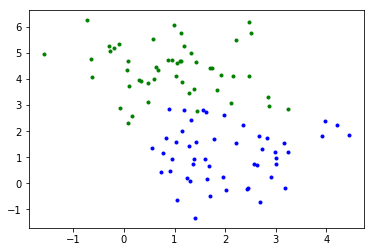

In [27]:
from sklearn.datasets.samples_generator import make_blobs
data, labels = make_blobs(n_samples=100, centers=2, n_features=2, random_state=0)
labels[labels==0] = -1
labels
len_data = len(data)
for pos, label in zip(data, labels):
    if label == 1:
        plt.plot(pos[0], pos[1], 'b.')
    else:
        plt.plot(pos[0], pos[1], 'g.')
##  性能評価方法

In [28]:
svm = soft_margin_SVM()
svm_estimator = svm.fit(data, labels)

In [29]:
svm_estimator.coef_

(-0.072947648543945698, 3.0173915265419375)

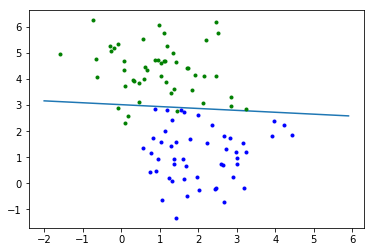

In [30]:
x = np.arange(-2, 6, 0.1)
w = svm_estimator.coef_
y = w[0]* x + w[1]
plt.plot(x, y)
idx = -1
for pos, label in zip(data, labels):
    idx += 1
    if label == 1:
        plt.plot(pos[0], pos[1], 'b.')
    else:
        plt.plot(pos[0], pos[1], 'g.')

もうちょっと真面目にやってみる

In [41]:
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

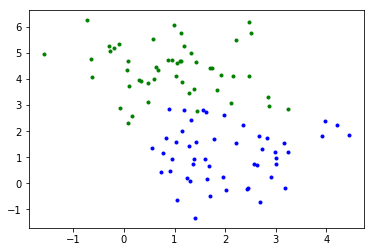

In [42]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=0)
y[y==0] = -1
for pos, label in zip(X, y):
    if label == 1:
        plt.plot(pos[0], pos[1], 'b.')
    else:
        plt.plot(pos[0], pos[1], 'g.')

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [44]:
parameters = {'C':np.linspace(0, 1, 10)}
svm = GridSearchCV(soft_margin_SVM(), parameters, cv=2)

In [45]:
svm.fit(X_test, y_test)
svm.best_estimator_

soft_margin_SVM(C=0.22222222222222221)

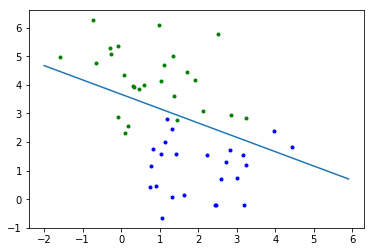

In [50]:
x = np.arange(-2, 6, 0.1)
w = svm.best_estimator_.coef_
y = w[0]* x + w[1]
plt.plot(x, y)
idx = -1
for pos, label in zip(X_test, y_test):
    idx += 1
    if label == 1:
        plt.plot(pos[0], pos[1], 'b.')
    else:
        plt.plot(pos[0], pos[1], 'g.')

Mean accuracy of the best estimater

In [52]:
svm.best_estimator_.score(X_test, y_test)

0.83999999999999997